In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as pl
%matplotlib inline  
import seaborn as sn

from FIRDeconvolution import FIRDeconvolution

In [2]:
# basic parameters

signal_sample_frequency = 10.0
event_1_gain, event_2_gain = 2.3, 0.85
noise_gain = 0.05

# create some events of which we will create and deconvolve responses. 

period_durs = np.random.gamma(4.0,1.5,size = 599)
events = np.r_[0, period_durs].cumsum()
events_1, events_2 = events[0::2], events[1::2]

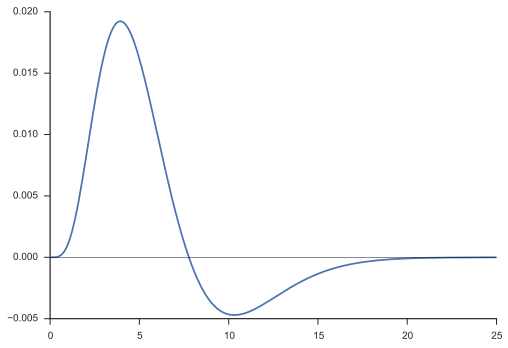

In [3]:
# We create an IRF, using a standard BOLD response.

def double_gamma_with_d(x, a1 = 6, a2 = 12, b1 = 0.9, b2 = 0.9, c = 0.35,d1=5.4,d2=10.8):
    return np.array([(t/(d1))**a1 * np.exp(-(t-d1)/b1) - c*(t/(d2))**a2 * np.exp(-(t-d2)/b2) for t in x])

hrf = double_gamma_with_d(np.linspace(0,25,25*signal_sample_frequency), a1 = 4.5, a2 = 10, d1 = 5.0, d2 = 10.0)
hrf = hrf/np.abs(hrf).sum()

pl.plot(np.linspace(0,25,25*signal_sample_frequency), hrf)
pl.axhline(0, lw=0.5, color = 'k')
sn.despine()

In [4]:
# Using this IRF we're going to create two signals and mix them together with some noise.

times = np.arange(0,events.max()+45.0,1.0/signal_sample_frequency)

event_1_in_times = np.array([(times>te) * (times<te+(1.0/signal_sample_frequency)) for te in events_1]).sum(axis = 0)
event_2_in_times = np.array([(times>te) * (times<te+(1.0/signal_sample_frequency)) for te in events_2]).sum(axis = 0)

signal_1 = sp.signal.fftconvolve(event_1_in_times, hrf, 'full')[:times.shape[0]]
signal_2 = sp.signal.fftconvolve(event_2_in_times, hrf, 'full')[:times.shape[0]]

# combine the two signals with one another, add noise and z-score
input_data = signal_1*event_1_gain + signal_2*event_2_gain
input_data += np.random.randn(input_data.shape[0]) * noise_gain
input_data =  (input_data - np.mean(input_data)) / input_data.std()

In [5]:
# determine deconvolution parameters

deconv_sample_frequency = 2.0
deconvolution_interval = [-5, 25]

In [6]:
# Up until here, it was just creating data. 
# Now, we'll use the actual deconvolution package.

# first, we initialize the object
fd = FIRDeconvolution(
            signal = input_data, 
            events = [events_1, events_2], 
            event_names = ['event_1', 'event_2'], 
            sample_frequency = signal_sample_frequency,
            deconvolution_frequency = deconv_sample_frequency,
            deconvolution_interval = deconvolution_interval
            )
# we then tell it to create its design matrix
fd.create_design_matrix()

# perform the actual regression
fd.regress()

# and partition the resulting betas according to the different event types
fd.betas_for_events()

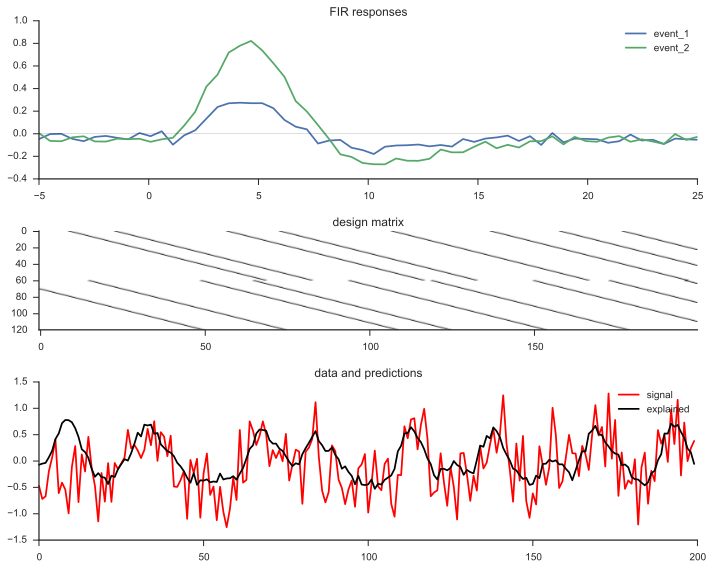

In [7]:
# and we see what we've done

plot_time = 200
f = pl.figure(figsize = (10,8))
s = f.add_subplot(311)
s.set_title('FIR responses')
for dec in fd.betas_per_event_type.squeeze():
	pl.plot(fd.deconvolution_interval_timepoints, dec)	
# pl.plot(fd.deconvolution_interval_timepoints, fd.betas_per_event_type.squeeze())	
pl.legend(fd.event_names)
sn.despine()

pl.axhline(0, lw=0.25, alpha=0.5, color = 'k')
s = f.add_subplot(312)
s.set_title('design matrix')
pl.imshow(fd.design_matrix[:,:plot_time], aspect = 0.075 * plot_time/fd.deconvolution_interval_size)
sn.despine()

s = f.add_subplot(313)
s.set_title('data and predictions')
pl.plot(fd.resampled_signal[:,:plot_time].T, 'r')
pl.plot(fd.predict_from_design_matrix(fd.design_matrix[:,:plot_time]).T, 'k')
pl.legend(['signal','explained'])
sn.despine()
pl.tight_layout()